In [28]:
import json
import sys

import h5py
import numpy as np
from progressbar import ProgressBar

from work.dataset.activitynet import ActivityNetDataset

In [ ]:
def get_temporal_proposals(prob):
    windows_sizes = np.array([4, 8, 16, 32])
    nb_instances = prob.shape[0]
    max_window_size = nb_instances // windows_sizes
    max_window_index = np.arange(4)[max_window_size > 0][-1]

    proposals = []
    for window_size in window_sizes[:max_window_index]:
        for i in range(nb_instances//window_size):
            proposal
            


In [39]:
from work.processing.output import get_top_k_predictions_score

def get_temporal_predictions(prob, fps=1, clip_length=16.):
    threshold = 0.50
    classes = np.argmax(prob, axis=1)
    top_activity, scores = get_top_k_predictions_score(classes, k=1)

    results = []
    if not top_activity:
        return results

    activity_prob = prob[:,top_activity[0]]

    activity_tag = np.zeros(activity_prob.shape)
    activity_tag[activity_prob>=threshold] = 1

    assert activity_tag.ndim == 1
    padded = np.pad(activity_tag, pad_width=1, mode='constant')
    dif = padded[1:] - padded [:-1]

    indexes = np.arange(dif.size)
    startings = indexes[dif == 1]
    endings = indexes[dif == -1]

    assert startings.size == endings.size

    for s, e in zip(startings, endings):
        score = np.mean(activity_prob[s:e])
        results.append({
            'score': score,
            'segment': [
                s * clip_length / fps,
                e * clip_length / fps
            ],
            'label': top_activity[0]
        })

    return results


In [40]:
predictions_path = '../predictions/predictions_06_e100.hdf5'

dataset = ActivityNetDataset(
    videos_path='../../../../../dataset/videos.json',
    labels_path='../../../../../dataset/labels.txt'
)

f_predictions = h5py.File(predictions_path, 'r')

subset = 'validation'
print('Generating results for {} subset...'.format(subset))
subset_predictions = f_predictions[subset]

progbar = ProgressBar(max_value=len(subset_predictions.keys()))
with open('../../../evaluation/data/result_template_{}.json'.format(subset), 'r') as f:
    results = json.load(f)

count = 0
progbar.update(0)
for video in dataset.get_subset_videos(subset):
    if video.video_id not in subset_predictions.keys():
        continue
    prediction = subset_predictions[video.video_id]
    #class_predictions = np.argmax(prediction, axis=1)
    temporal_predictions = get_temporal_predictions(prediction, fps=video.fps)
    for p in temporal_predictions:
        label = dataset.labels[p['label']][1]
        p['label'] = label

    results['results'][video.video_id] = temporal_predictions
    count += 1
    progbar.update(count)

progbar.finish()

f_predictions.close()

Generating results for validation subset...


100% (4856 of 4856) |######################| Elapsed Time: 0:00:52 Time: 0:00:52


In [41]:
sum(len(results['results'][k]) for k in results['results'].keys())

13779

# Temporal Proposals

In [42]:
import json

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [43]:
# Modify this paths
ANNOTATION_FILE = '../../../evaluation/data/activity_net.v1-3.min.json'
SUBSET = 'validation'

In [44]:
# Read json file containing the annotations
with open(ANNOTATION_FILE, 'r') as fobj:
    data = json.load(fobj)['database']

# Parsing and looking for agnostic segments of an intended subset.
video_id_fmt = '{}'
gt_s_init, gt_s_end, video_id = [], [], []
for vid, vitem in data.iteritems():
    if vitem['subset'] != SUBSET:
        continue
    for ann in vitem['annotations']:
        gt_s_init.append(ann['segment'][0])
        gt_s_end.append(ann['segment'][1])
        video_id.append(video_id_fmt.format(vid))
# Creates ground truth data frame.
ground_truth_df = pd.DataFrame({'s-init': gt_s_init, 
                                's-end': gt_s_end,
                                'video-id': video_id})

In [45]:
# Looking for videos in the subset
intended_videos = []
for vid, vitem in data.iteritems():
    if vitem['subset'] == SUBSET:
        intended_videos.append(vid)

# Reading proposals from HDF5 file.
s_init, s_end, score, video_id = [], [], [], []
fobj = results['results']
for vid in fobj.keys():
    if vid not in intended_videos:
        continue
    for prediction in fobj[vid]:
        s_init.append(prediction['segment'][0])
        s_end.append(prediction['segment'][1])
        score.append(prediction['label'])
        video_id.append(vid)
    #s_init.extend(fobj[vid]['segment-init'].value.tolist())
    #s_end.extend(fobj[vid]['segment-end'].value.tolist())
    #score.extend(fobj[vid]['score'].value.tolist())
    #video_id.extend(np.repeat(vid, fobj[vid]['segment-init'].value.size).tolist())
proposals_df = pd.DataFrame({'s-init': s_init, 
                             's-end': s_end, 
                             'score': score,
                             'video-id': video_id})
print 'Average number of proposals: {}'.format(proposals_df.shape[0] / float(len(intended_videos)))

Average number of proposals: 2.79719853837


In [46]:
def segment_iou(target_segments, test_segments):
    """Compute intersection over union btw segments
    Parameters
    ----------
    target_segments : ndarray
        2-dim array in format [m x 2:=[init, end]]
    test_segments : ndarray
        2-dim array in format [n x 2:=[init, end]]
    Outputs
    -------
    iou : ndarray
        2-dim array [m x n] with IOU ratio.
    Note: It assumes that target-segments are more scarce that test-segments
    """
    if target_segments.ndim != 2 or test_segments.ndim != 2:
        raise ValueError('Dimension of arguments is incorrect')

    m, n = target_segments.shape[0], test_segments.shape[0]
    iou = np.empty((m, n))
    for i in xrange(m):
        tt1 = np.maximum(target_segments[i, 0], test_segments[:, 0])
        tt2 = np.minimum(target_segments[i, 1], test_segments[:, 1])

        # Non-negative overlap score
        intersection = (tt2 - tt1).clip(0)
        union = ((test_segments[:, 1] - test_segments[:, 0]) +
                 (target_segments[i, 1] - target_segments[i, 0]) -
                 intersection)
        # Compute overlap as the ratio of the intersection
        # over union of two segments at the frame level.
        iou[i, :] = intersection / union
    return iou

def recall_vs_iou_thresholds(proposal_df, df, iou_threshold=np.array([0.5])):
    vds = proposal_df['video-id'].unique()
    score_lst = []
    # Compute iou score
    for i, v in enumerate(vds):
        # Proposals
        idx = proposal_df['video-id'] == v
        this_df = proposal_df.loc[idx]
        proposals = np.stack((this_df['s-init'], 
                              this_df['s-end']), axis=-1)

        # Sort proposals
        idx = this_df['score'].argsort()[::-1]
        proposals = proposals[idx, :]

        # Annotations
        jdx = df['video-id'] == v
        ann_df = df.loc[jdx]
        annotations = np.stack((ann_df['s-init'],
                                ann_df['s-end']), axis=-1)
        if proposals.ndim == 1:
            proposals = proposals[np.newaxis, :]
        score_lst.append(segment_iou(annotations, proposals))
        if not (i+1)%500:
            print 'Scored videos: {}'.format(i+1)
    matches = np.zeros((vds.shape[0], iou_threshold.shape[0]))
    pos = np.zeros(vds.shape[0])
    # Matching
    recall = np.empty(iou_threshold.shape[0])
    for cidx, this_iou in enumerate(iou_threshold):
        # Score analysis per video.
        for i, sc in enumerate(score_lst):
            pos[i] = sc.shape[0] # Positives per video.
            lmt = int(sc.shape[1])
            matches[i, cidx] = ((sc[:, :lmt] >= this_iou).sum(axis=1) > 0).sum()
        this_recall = matches[:, cidx].sum() / pos.sum()
        recall[cidx] = this_recall
    return recall

In [47]:
iou_thrs = np.arange(0.1, 0.6, 0.1)
recall = recall_vs_iou_thresholds(proposals_df, ground_truth_df, iou_threshold=iou_thrs)

/mnt/imatge-work/amontes/activitynet/venv/lib/python2.7/site-packages/ipykernel/__main__.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Scored videos: 500
Scored videos: 1000
Scored videos: 1500
Scored videos: 2000
Scored videos: 2500
Scored videos: 3000


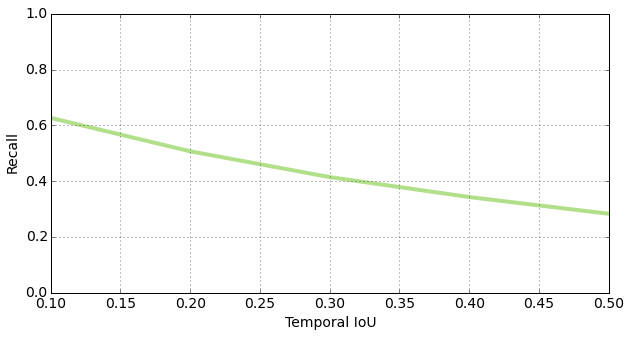

In [48]:
fn_size = 14
plt.figure(num=None, figsize=(10, 5))
plt.plot(iou_thrs, recall, linewidth=4, color=np.array([178,223,138])/255.0)
plt.xlabel('Temporal IoU', fontsize=fn_size)
plt.ylabel('Recall', fontsize=fn_size)
plt.grid(b=True, which="both")
plt.setp(plt.axes().get_xticklabels(), fontsize=fn_size)
plt.setp(plt.axes().get_yticklabels(), fontsize=fn_size)
plt.xlim([0.1, 0.5])
plt.ylim([0, 1])
plt.show()